In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
pd.set_option('display.max_colwidth', -1)
import glob

from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt

<ipython-input-1-b8a0bc152174>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
DATASET_SITE_PATH

'/home/prash/datasets/v20210419/HIL'

In [3]:
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, medications_df, medications_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)

In [13]:
df_adt = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'ADT.txt'),
        delimiter='|')
service_code_dict = {'ANR' : 'Anesthesiology', 'CAR' : 'cardiology', 'CGD' : 'general_surgery_and_digestive',
                     'DER' : 'dermatology', 'DIG' : 'digestive_system', 'END' : 'endocrinology', 'HEM' : 'hematology',
                    'GIN' : 'gynaecology', 'MIR' : 'residents_interns', 'MIV' : 'internal_medicine', 
                    'MNU': 'neuclear_medicine', 'NFR' : 'Nephrology', 'NML' : 'lung', 'NRL' :'neurology',
                    'OBS': 'obstetrics', 'OFT':'opthalmology', 'ONC' : 'oncology', 'ORL' : 'ENT',
                    'REU':'rheumatology', 'URO': 'urology'}

## Plotting stay lengths by service ID

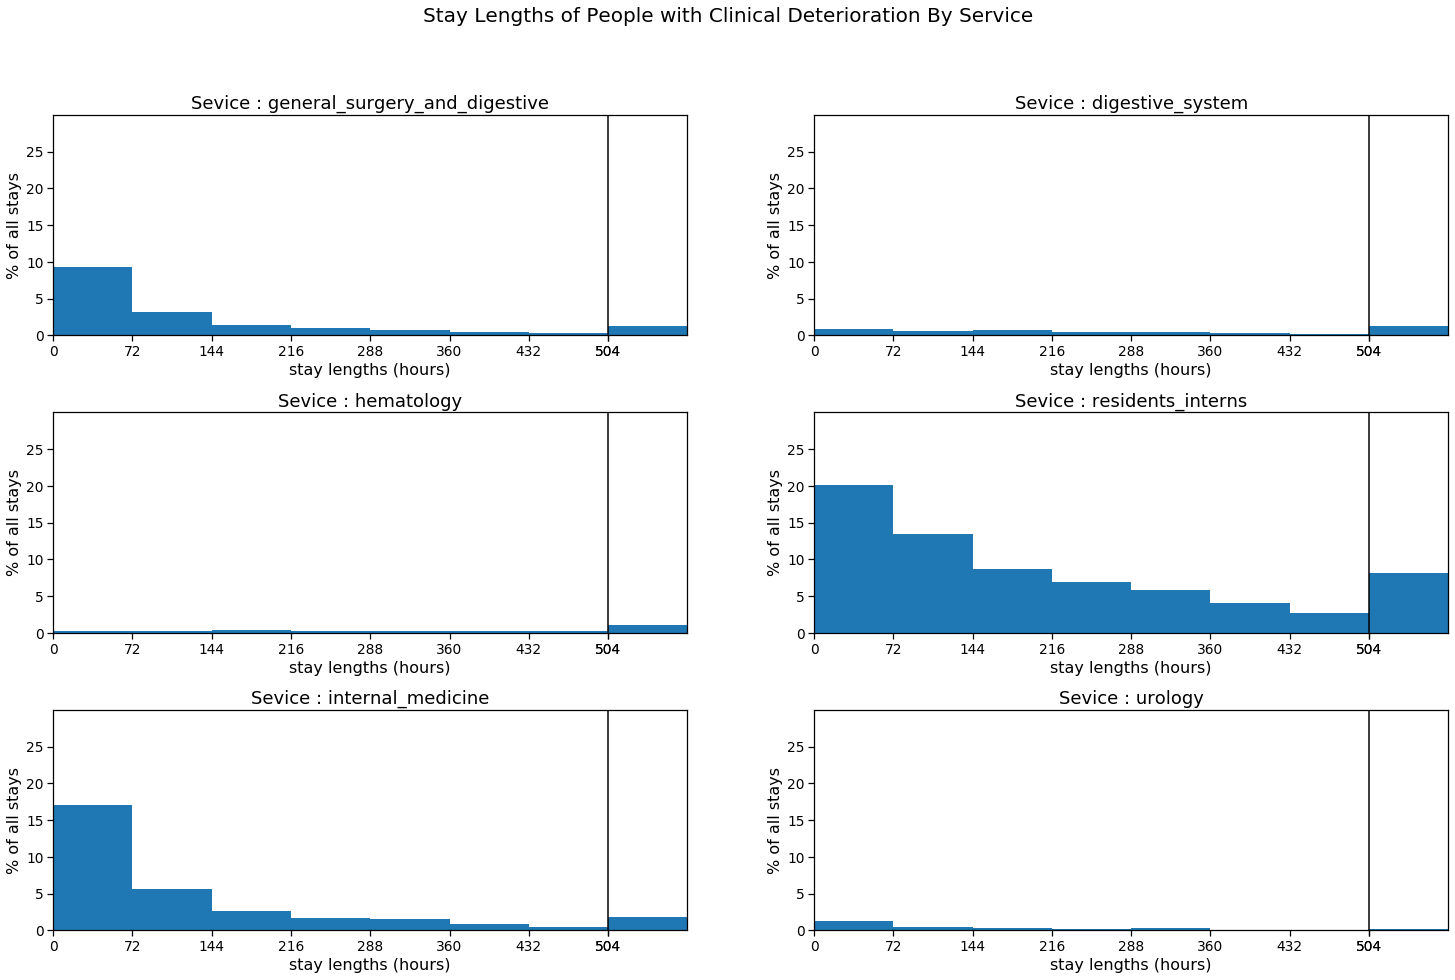

In [6]:
def get_stays_by_service_ids(service_code):
    curr_service_adms_df = df_adt[(df_adt.VALUE_TEXT==service_code) & 
                                  (df_adt.DESCRIPTION == 'service_start_ts')].drop_duplicates(subset='ADMISSION_ID').copy()
    curr_service_adms_df.rename(columns = { 'PATIENT_ID':'patient_id',
                                           'ADMISSION_ID':'hospital_admission_id',
                                           'FACILITY_CD':'facility_code'}, inplace=True)
    return curr_service_adms_df
    


key_cols  = ['patient_id', 'hospital_admission_id', 'facility_code']

# select services to plot
plot_service_list = ['CGD', 'DIG', 'HEM', 'MIR', 'MIV', 'URO']

f,axs =  plt.subplots(3,2, figsize=(25,15))
axs_list = [i for i in axs.reshape(-1,1)]
sns.set_context("notebook", font_scale=1.25)
fontsize=16
for p, service in enumerate(plot_service_list):
    curr_ax = axs_list[p][0]
    df_transfer_to_icu_pos_outcomes = outcomes_df[outcomes_df.clinical_deterioration_outcome==1].copy()
    curr_service_adms_df = get_stays_by_service_ids(service)
    curr_service_stay_lengths = pd.merge(curr_service_adms_df, df_transfer_to_icu_pos_outcomes, 
                                         on=key_cols, how='inner')['stay_length']
    max_los = curr_service_stay_lengths.max()
    max_t = 504
    step=72
    bins = np.arange(0, max_t+1, step)
    if max_los > max_t+1:
        bins=np.insert(bins, len(bins), max_los)
    x = np.asarray(curr_service_stay_lengths)
    curr_ax.hist(x, bins=bins, weights=np.ones(len(x))*100 / len(df_transfer_to_icu_pos_outcomes))
#     curr_ax.hist(x, bins=bins)
    curr_ax.set_xlabel('stay lengths (hours)', fontsize=fontsize)
    curr_ax.set_ylabel('% of all stays', fontsize=fontsize)
    curr_ax.set_xlim([0, max_t+step])
    bins[-1]=max_t
    curr_ax.set_xticks(bins)
    ymin=0
    ymax=30
    curr_ax.vlines(max_t, ymin=ymin, ymax=ymax)
    curr_ax.set_ylim([ymin, ymax])
    curr_ax.set_yticks(np.arange(ymin, ymax, 5))
    curr_ax.set_title('Sevice : %s'%service_code_dict[service], fontsize=fontsize+2)

plt.subplots_adjust(hspace=0.35)
plt.suptitle('Stay Lengths of People with Clinical Deterioration By Service', fontsize=fontsize+4)
plt.show()
f.savefig('stay_lengths_by_service_code_HUF.png')
f.savefig('stay_lengths_by_service_code_HUF.pdf', bbox_inches='tight', pad_inches=0)


In [11]:
curr_service_adms_df

,facility_code,hospital_admission_id,patient_id,DESCRIPTION,VALUE_TEXT,TS
1713,1,11019395,1792403,service_start_ts,URO,2021-06-18 09:38:00
2289,1,11025904,1708628,service_start_ts,URO,2022-10-28 08:33:00
2439,1,11027905,1403945,service_start_ts,URO,2019-01-06 09:07:00
2573,1,11028868,1278649,service_start_ts,URO,2019-10-07 08:09:00
3332,1,11038601,1608577,service_start_ts,URO,2021-01-08 07:56:00
...,...,...,...,...,...,...
8393711,1,19356863,1476788,service_start_ts,URO,2021-04-06 21:51:00
8469105,1,19440263,1641274,service_start_ts,URO,2023-05-01 12:37:00
8593323,1,19577381,1226029,service_start_ts,URO,2021-04-14 20:15:00
8803358,1,19807655,1371142,service_start_ts,URO,2022-03-04 12:13:00


## Show multiple lab names

In [4]:
lab_csv_path = os.path.join('/rgi/data/HUF/deidentified_data', 'LABS.txt')
lookup_csv_path = os.path.join('/rgi/data/HUF/deidentified_data', 'LOINC_LOOKUP.txt')

# get the lab information
df_labs = pd.read_csv(lab_csv_path, delimiter='|', quotechar=None, quoting=3)

# get the loinc lookup file to get description of the lab test
df_loinc = pd.read_csv(lookup_csv_path, delimiter='|')

# remove duplicate loincs
df_loinc.drop_duplicates(subset=['LOINC'], keep='last', inplace=True)

# merge with labs csv to get lab descriptions based on LOINC
df_labs = pd.merge(df_labs, df_loinc, on='LOINC', how='inner')

In [11]:
urea_inds = df_loinc.DESCRIPTION.str.contains('Urea')
df_loinc[urea_inds]

,LOINC,VALUE,DESCRIPTION,CODING_STANDARD
699,6299-2,UREA,Urea nitrogen [Mass/volume] in Blood,Version 2.61
704,3094-0,Urea 1006,Urea nitrogen [Mass/volume] in Serum or Plasma,Version 2.61
706,3095-7,"Urea, orina espontanea 6813",Urea nitrogen [Mass/volume] in Urine,Version 2.61
707,3096-5,Urea/24 h 6109,Urea nitrogen [Mass/time] in 24 hour Urine,Version 2.61


In [13]:
o2_inds = df_loinc.DESCRIPTION.str.contains('Oxygen')
df_loinc[o2_inds]

,LOINC,VALUE,DESCRIPTION,CODING_STANDARD
647,20564-1,Saturaci—n O2,Oxygen saturation in Blood,Version 2.61
735,19218-7,ctO2(a),Oxygen content in Arterial blood,Version 2.61
755,2703-7,pO2 A,Oxygen [Partial pressure] in Arterial blood,Version 2.61
756,2705-2,pO2 V,Oxygen [Partial pressure] in Venous blood,Version 2.61
757,2704-5,pO2 s. capilar,Oxygen [Partial pressure] in Capillary blood,Version 2.61
759,2708-6,sO2m (saturación medida de oxígeno) 654,Oxygen saturation in Arterial blood,Version 2.61
761,51732-6,saturaci—n O2 s. capilar,Oxygen saturation Calculated from oxygen par...,Version 2.61


## Show boxplots

## Shpw labs and vitals

In [ ]:
site_name = D_CONFIG['SITE_NAME']
vitals = parse_feature_cols(vitals_data_dict)
f_v, axs_v = plt.subplots(1,1, figsize=(12, 10))
sns.boxplot(data=vitals_df[vitals], ax=axs_v)
axs_v.tick_params(axis='x', rotation=60)
yticks = np.arange(0, 650, 50)
axs_v.set_yticks(yticks)
axs_v.set_ylim([0, 650])
axs_v.set_title(site_name + ' Vitals Value Ranges')
f_v.savefig('%s_vital_ranges.png'%site_name)
f_v.savefig('%s_vital_ranges.pdf'%site_name, bbox_inches='tight', pad_inches=0)
plt.show()


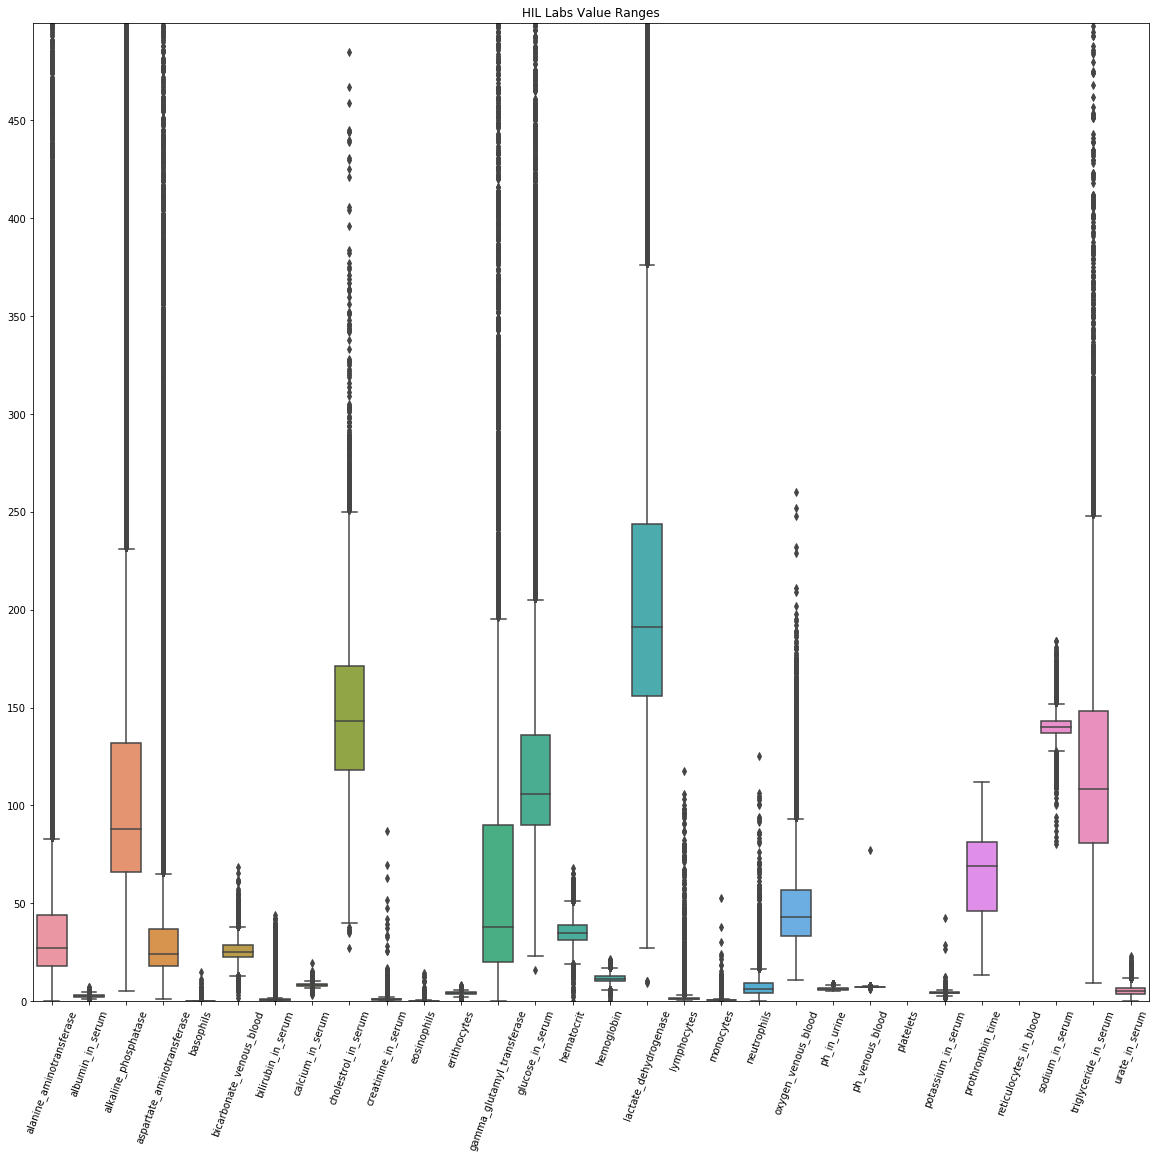

In [4]:
site_name = D_CONFIG['SITE_NAME']
labs = parse_feature_cols(labs_data_dict)
f_l, axs_l = plt.subplots(1,1, figsize=(20, 18))
sns.boxplot(data=labs_df[labs], ax=axs_l)
axs_l.tick_params(axis='x', rotation=70)
ymax=500
yticks = np.arange(0, ymax, 50)
axs_l.set_yticks(yticks)
axs_l.set_ylim([0, ymax])
axs_l.set_title(D_CONFIG['SITE_NAME']+ ' Labs Value Ranges')
f_l.savefig('%s_lab_ranges.png'%site_name)
f_l.savefig('%s_lab_ranges.pdf'%site_name, bbox_inches='tight', pad_inches=0)
plt.show()

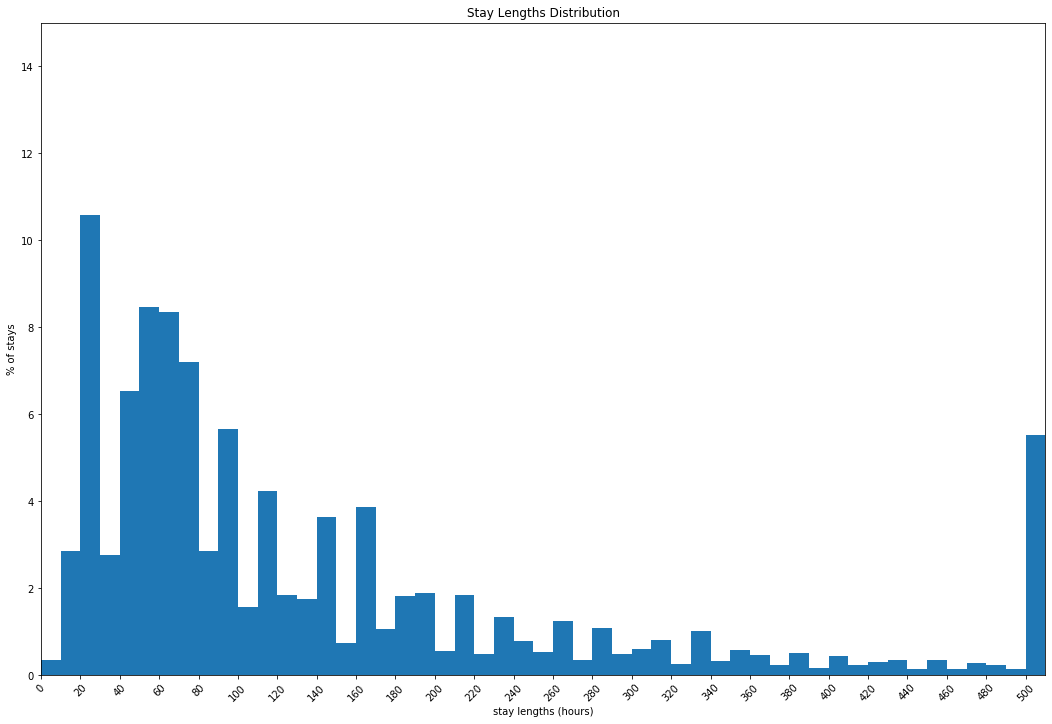

In [6]:
f,axs =  plt.subplots(1,1)
max_los = outcomes_df['stay_length'].max()
max_t = 500
step=10
bins = np.arange(0, max_t+1, step)
bins=np.insert(bins, len(bins), max_los)
x = outcomes_df['stay_length'].to_numpy()
plt.hist(x, bins=bins, weights=np.ones(len(x))*100 / len(x))
plt.xlabel('stay lengths (hours)')
plt.ylabel('% of stays')
plt.xlim([0, max_t+step])
bins[-1]=max_t
axs.set_xticks(bins[::2])
# x_ticks = np.arange(0, max_t+10, 24)
# axs.set_xticks(x_ticks)
axs.tick_params(axis='x', rotation=45)
#     axs.set_yticks(np.arange(0, 2500, 100))
axs.set_ylim([0, 15])
axs.set_title('Stay Lengths Distribution')
f.savefig('%s_stay_lengths.png'%site_name)
f.set_size_inches([18, 12])


In [12]:
# f,axs = plt.subplots(1,1,figsize=(10,8))
# plt.hist(np.asarray(outcomes_df['clinical_deterioration_outcome']), bins=2)
site_name = D_CONFIG['SITE_NAME']
num_pos = (outcomes_df['clinical_deterioration_outcome']==1).sum()
tot = len(outcomes_df)

print('Number of admissions in %s : %s'%(site_name, tot))
print('Number of clinical deteriorations in %s : %s'%(site_name, num_pos))
print('percentage clinical deteriorations in %s : %.4f %%'%(site_name, num_pos*100/tot))

Num admissions in HUF : 41731
Num clinical deteriorations in HUF : 599
percentage clinical deteriorations in HUF : 1.4354 %


In [5]:
site_name = D_CONFIG['SITE_NAME']
num_pos = (outcomes_df['clinical_deterioration_outcome']==1).sum()
tot = len(outcomes_df)

print('Number of admissions in %s : %s'%(site_name, tot))
print('Number of clinical deteriorations in %s : %s'%(site_name, num_pos))
print('percentage clinical deteriorations in %s : %.4f %%'%(site_name, num_pos*100/tot))

Number of admissions in HIL : 56525
Number of clinical deteriorations in HIL : 426
percentage clinical deteriorations in HIL : 0.7536 %


## Check why certain labs in HIL are missing

In [3]:
lab_csv_path = os.path.join('/rgi/data/HIL/deidentified_data', 'LABS.txt')
lookup_csv_path = os.path.join('/rgi/data/HIL/deidentified_data', 'LOINC_LOOKUP.txt')

# get the lab information
df_labs = pd.read_csv(lab_csv_path, delimiter='|', quotechar=None, quoting=3)

# get the loinc lookup file to get description of the lab test
df_loinc = pd.read_csv(lookup_csv_path, delimiter='|')

# remove duplicate loincs
df_loinc.drop_duplicates(subset=['LOINC'], keep='last', inplace=True)

# merge with labs csv to get lab descriptions based on LOINC
df_labs = pd.merge(df_labs, df_loinc, on='LOINC', how='inner')

In [27]:
df_labs[df_labs.LOINC=='14196-0']

,FACILITY_CD,PATIENT_ID,EVENT_TYPE,ID_ORDER,LOINC,VALUE_x,REF_MIN_VALUE,REF_MAX_VALUE,ABNORMAL_LOW,ABNORMAL_HIGH,UNIT,TS,VALUE_y,DESCRIPTION,CODING_STANDARD
23516482,2,2611560,1,28658684,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-04-15 09:39:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516483,2,2611560,1,28658684,14196-0,40,30.0,90.0,NaN,NaN,SIN UNIDAD,2023-04-15 09:39:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516484,2,2611560,1,23116658,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-06-03 08:50:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516485,2,2611560,1,23116658,14196-0,46,30.0,90.0,NaN,NaN,SIN UNIDAD,2023-06-03 08:50:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516486,2,243855,1,26091318,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-04-18 07:49:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23540193,2,2507344,2,27957022,14196-0,52,25.0,100.0,NaN,NaN,SIN UNIDAD,2026-01-22 01:16:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540194,2,2530825,2,21564028,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2025-12-13 15:43:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540195,2,2530825,2,21564028,14196-0,35.5,25.0,100.0,NaN,NaN,SIN UNIDAD,2025-12-13 15:43:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540196,2,2981617,2,24098114,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2026-02-10 21:37:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61


## Get the admissions removed by exclusion criteria

In [2]:
sys.path.append('/home/prash/madrid-data-prep/demographics/')
from make_standard_demographics import filter_admissions_for_inclusion_criteria

In [3]:
df_adt = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'ADT.txt'),
        delimiter='|')
df_pd = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'PATIENT_DEMOGRAPHICS.txt'),
        delimiter='|')

df_demographics = filter_admissions_for_inclusion_criteria(df_adt, df_pd)

Total Hospital Admissions : 74635
Total neonatal hospital admissions : 2249


In [4]:
df_demographics.shape

(72380, 6)

In [5]:
df_adt_hadm = df_adt[df_adt.DESCRIPTION=='hospital_admission_ts'].copy()

print('Total Hospital Admissions : %s'%len(df_adt_hadm.ADMISSION_ID.unique()))

# get neo natal admissions
df_adt_neo = df_adt[df_adt.VALUE_TEXT=='NEO'].copy()

# remove neo natal admissions from non-ER admissions
non_neo_hadm_inds = ~(df_adt_hadm.ADMISSION_ID.isin(df_adt_neo.ADMISSION_ID.unique()))
print('Total neonatal hospital admissions : %s'%(~non_neo_hadm_inds).sum())

df_adt_hadm_non_neo = df_adt_hadm.loc[non_neo_hadm_inds,:].copy().reset_index(drop=True)

Total Hospital Admissions : 74635
Total neonatal hospital admissions : 2249


## Look into medication information

- What is the difference between the MEDICATION_ADMINISTRATION.txt and MEDICATION_ORDER.txt?


In [2]:
DATASET_RAW_PATH = '/rgi/data/HUF/deidentified_data'
medication_administration_df = pd.read_csv(os.path.join(DATASET_RAW_PATH, 'MEDICATION_ADMINISTRATION.txt'), 
                                           delimiter='|')
# medication_order_df = pd.read_csv(os.path.join(DATASET_RAW_PATH, 'MEDICATION_ORDER.txt'),
#                                  delimiter='|')

/home/prash/.conda/envs/madrid_data_prep/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
medication_administration_df.ATC_CD = medication_administration_df.ATC_CD.astype(str)
atc_second_levels = [i[:3] for i in medication_administration_df.ATC_CD] 
medication_administration_df['atc_second_levels'] = atc_second_levels

In [19]:
all_second_levels = list(medication_administration_df['atc_second_levels'].unique())
legal_second_levels = [i for i in all_second_levels if (i[0].isalpha() and len(i)==3 and i!='nan')]

In [20]:
second_level_medications_dict = dict.fromkeys(legal_second_levels)

for k,v in second_level_medications_dict.items():
    second_level_medications_dict[k] = '%s_second_level_medication'%k

second_level_medications_dict

{'B05': 'B05_second_level_medication',
 'N02': 'N02_second_level_medication',
 'A03': 'A03_second_level_medication',
 'A02': 'A02_second_level_medication',
 'M01': 'M01_second_level_medication',
 'R03': 'R03_second_level_medication',
 'A06': 'A06_second_level_medication',
 'R05': 'R05_second_level_medication',
 'J01': 'J01_second_level_medication',
 'H02': 'H02_second_level_medication',
 'N05': 'N05_second_level_medication',
 'H01': 'H01_second_level_medication',
 'B01': 'B01_second_level_medication',
 'N01': 'N01_second_level_medication',
 'B03': 'B03_second_level_medication',
 'S01': 'S01_second_level_medication',
 'A04': 'A04_second_level_medication',
 'N06': 'N06_second_level_medication',
 'H03': 'H03_second_level_medication',
 'A12': 'A12_second_level_medication',
 'C03': 'C03_second_level_medication',
 'R06': 'R06_second_level_medication',
 'A10': 'A10_second_level_medication',
 'C10': 'C10_second_level_medication',
 'L01': 'L01_second_level_medication',
 'V06': 'V06_second_level

In [ ]:
first_level_medications_dict = {'A' : 'alimentary_tract_medication', 'B' : 'blood_medication',
                                'C' : 'cardiovarscular_medication', 'D' : 'dermatological_medication',
                               'G' : 'genito_urinary_medication', 'H' : 'systemic_hormonal_medication',
                               'J' : 'antiinfective_medication', 'L': 'antineoplastic_medication',
                               'M' : 'muskuloskeletal_medication', 'N' : 'nervous_system_medication',
                               'P' : 'antiparasitic_medication', 'R' : 'respiratory_medication',
                               'S' : 'sensory_organ_medication', 'V' : 'various_other_medication'}

## get a list of all the medications befing administered for out cohort 

In [5]:
medication_administration_df.rename(columns={'PATIENT_ID': 'patient_id'}, inplace=True)

In [6]:
_, _, _, _, demographics_df, demographics_data_dict, _, _, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)

# get only medications of the selected cohort
keep_inds = medication_administration_df.patient_id.isin(demographics_df.patient_id.unique())
medication_administration_df = medication_administration_df[keep_inds]

In [7]:
# get medication name from lookup
medication_code_lookup_df = pd.read_csv(os.path.join(DATASET_RAW_PATH, 'ATC_CD_LOOKUP.txt'), delimiter='|')
medication_administration_df = pd.merge(medication_administration_df, medication_code_lookup_df, on='ATC_CD', how='inner')

In [8]:
n_drugs = len(medication_administration_df['DRUG_NAME'].unique())
n_patients = len(demographics_df['patient_id'].unique())
print('Total number of patients : %s'%n_patients)
print('Number of drugs administered : %s'%n_drugs)


Total number of patients : 38989
Number of drugs administered : 523


In [9]:
medication_administration_df.head()

,FACILITY_CD,patient_id,ORDER_ID,ORDER_MED_ID,PHAPRO_CD,ATC_CD,VALUE,UNIT,TS,DRUG_NAME
0,1,1417921,1461794,17372377,370151002,N02BE01,1.0,NaN,2018-11-04 18:00:00,PARACETAMOL 10MG/ML VIAL 100 ML
1,1,1417921,1461794,17372377,370151002,N02BE01,1.0,NaN,2018-11-05,PARACETAMOL 10MG/ML VIAL 100 ML
2,1,1417921,1461794,17372377,370151002,N02BE01,1.0,NaN,2018-11-05 06:00:00,PARACETAMOL 10MG/ML VIAL 100 ML
3,1,1417921,1461794,17372377,370151002,N02BE01,1.0,NaN,2018-11-05 12:00:00,PARACETAMOL 10MG/ML VIAL 100 ML
4,1,1417921,1461794,17372377,370151002,N02BE01,1.0,NaN,2018-11-05 18:00:00,PARACETAMOL 10MG/ML VIAL 100 ML


In [10]:
# sns.countplot(x='DRUG_NAME', data=medication_administration_df)
# plt.show()

# get the of counts of patients being administered each drug 
counts_per_med = medication_administration_df.groupby('ATC_CD').nunique()['patient_id']

In [13]:
a = [i for i in medication_code_lookup_df.DRUG_NAME if 'CEFAZOLINA' in i]
a

['CEFAZOLINA 2G VIAL', 'CEFAZOLINA 1G VIAL']

In [51]:
n_top = 30
top_counts_per_med = counts_per_med.sort_values(ascending=False)[:n_top]
top_meds = list(top_counts_per_med.index)
top_counts = top_counts_per_med.values

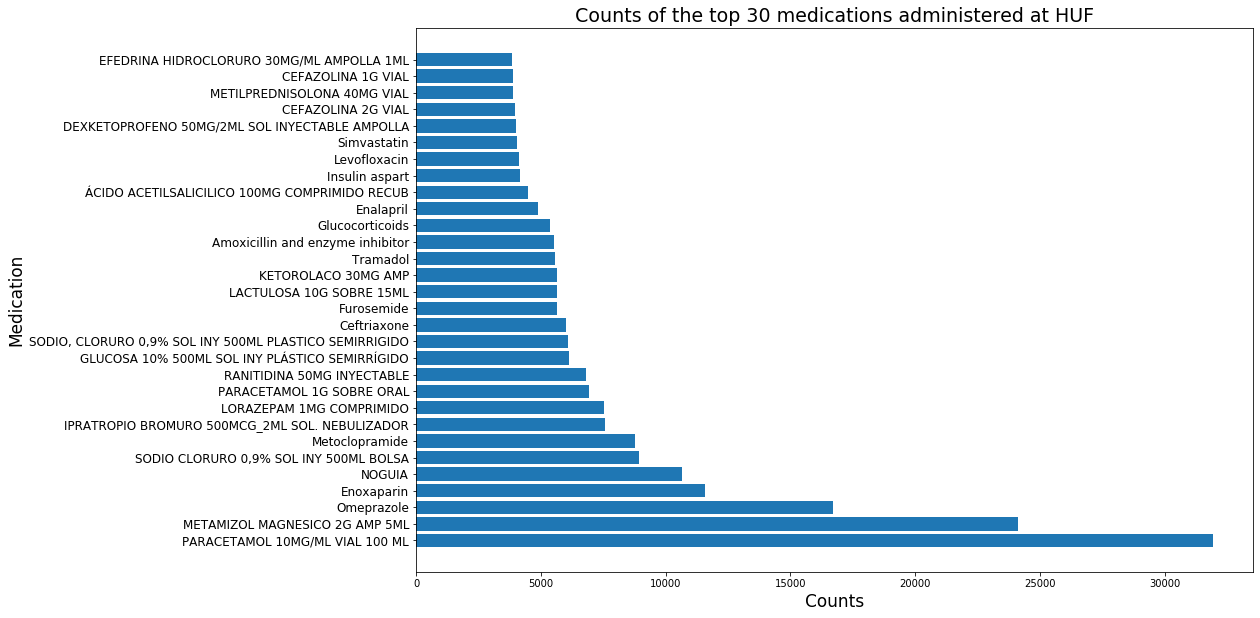

In [70]:
fontsize=12
f, axs = plt.subplots(1, 1, figsize = (15,10))
x = np.arange(len(top_meds))
axs.barh(x, top_counts)
axs.set_yticks(x)
axs.set_yticklabels(top_meds, fontsize=fontsize)
axs.set_ylabel('Medication', fontsize=fontsize+5)
axs.set_xlabel('Counts', fontsize=fontsize+5)
plt.title('Counts of the top 30 medications administered at HUF', fontsize=fontsize+7)
plt.show()
f.savefig('Medication_counts.png')


In [55]:
## plot the medication values administered for the top drugs
keep_inds = medication_administration_df.DRUG_NAME.isin(top_meds)
medication_administration_df = medication_administration_df[keep_inds]

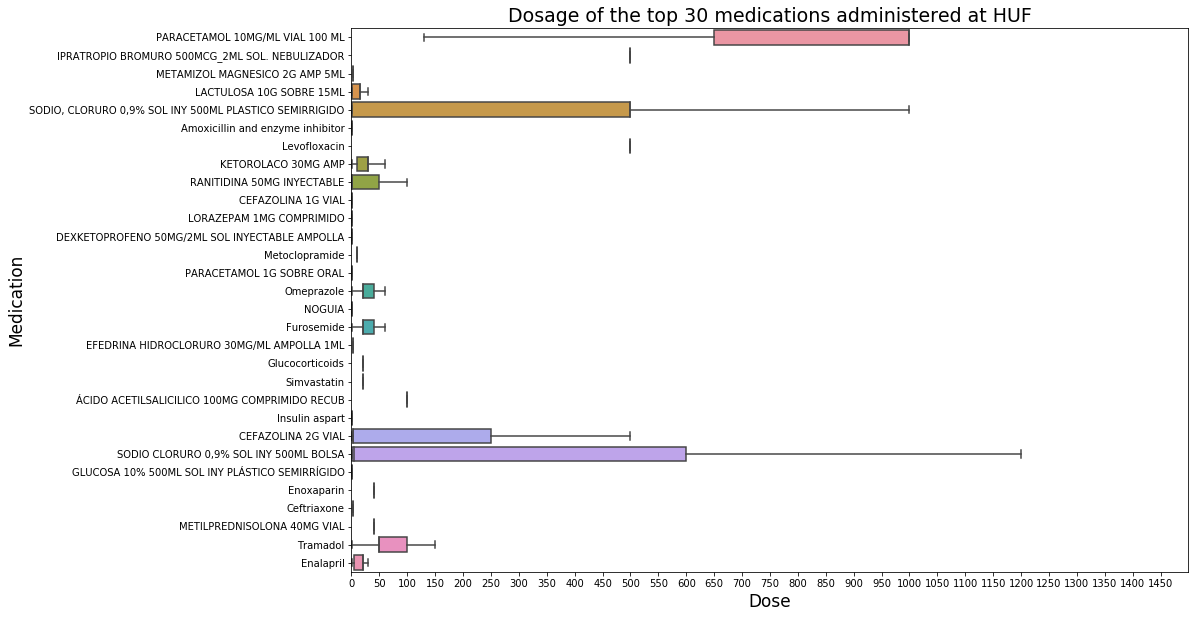

In [69]:
fontsize=12
xticks = np.arange(0, 1500, 50)
xticklabels = [str(x) for x in xticks]
f, axs = plt.subplots(1, 1, figsize = (15,10))
sns.boxplot(data=medication_administration_df, x='VALUE', y='DRUG_NAME', ax=axs, showfliers=False)
axs.set_xlim([0, 1500])
axs.set_ylabel('Medication', fontsize=fontsize+5)
axs.set_xlabel('Dose', fontsize=fontsize+5)
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels)
plt.title('Dosage of the top 30 medications administered at HUF', fontsize=fontsize+7)
plt.show()
f.savefig('Medication_dosages.png')

## Get medications information post processing

In [2]:
_, _, _, _, demographics_df, demographics_data_dict, medications_df, medications_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)


In [3]:
# plot the % of patients administered each category of drugs
id_cols = parse_id_cols(medications_data_dict)

# create dataframe that checks if medication has been administered at all
is_medication_adm_df = medications_df.groupby(id_cols).max().reset_index()

In [4]:
medication_cols = parse_feature_cols(medications_data_dict)

tot_adms = len(demographics_df.hospital_admission_id.unique())
medication_perc = is_medication_adm_df[medication_cols].sum()*100/tot_adms

In [5]:
medication_perc

alimentary_tract_medication     13.508706
antiinfective_medication        9.514814 
antineoplastic_medication       0.136960 
antiparasitic_medication        0.483297 
blood_medication                15.604043
cardiovarscular_medication      8.367180 
dermatological_medication       0.302257 
genito_urinary_medication       0.595069 
muskuloskeletal_medication      4.470892 
nervous_system_medication       29.455937
respiratory_medication          3.753030 
sensory_organ_medication        1.501842 
systemic_hormonal_medication    8.433299 
various_other_medication        0.772961 
dtype: float64

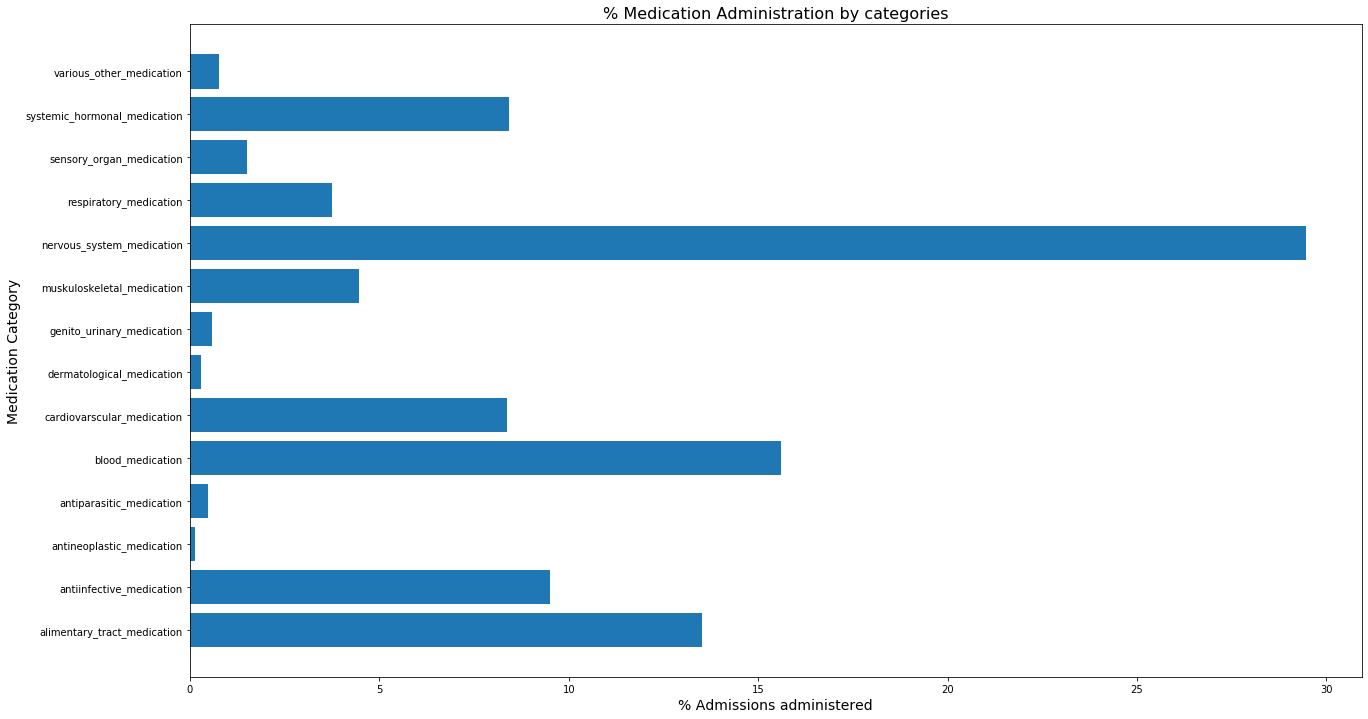

In [22]:
ticks = range(len(medication_perc))
ticklabels = list(medication_perc.keys())
fontsize = 10
f, axs = plt.subplots(1, 1, figsize=(21, 12))
axs.barh(y=ticks, width=medication_perc.values)
axs.set_yticks(ticks)
axs.set_yticklabels(ticklabels)
axs.set_ylabel('Medication Category', fontsize = fontsize+4)
axs.set_xlabel('% Admissions administered', fontsize = fontsize+4)
axs.set_title('% Medication Administration by categories', fontsize = fontsize+6)
f.savefig('perc_meds_administered.png')
plt.show()

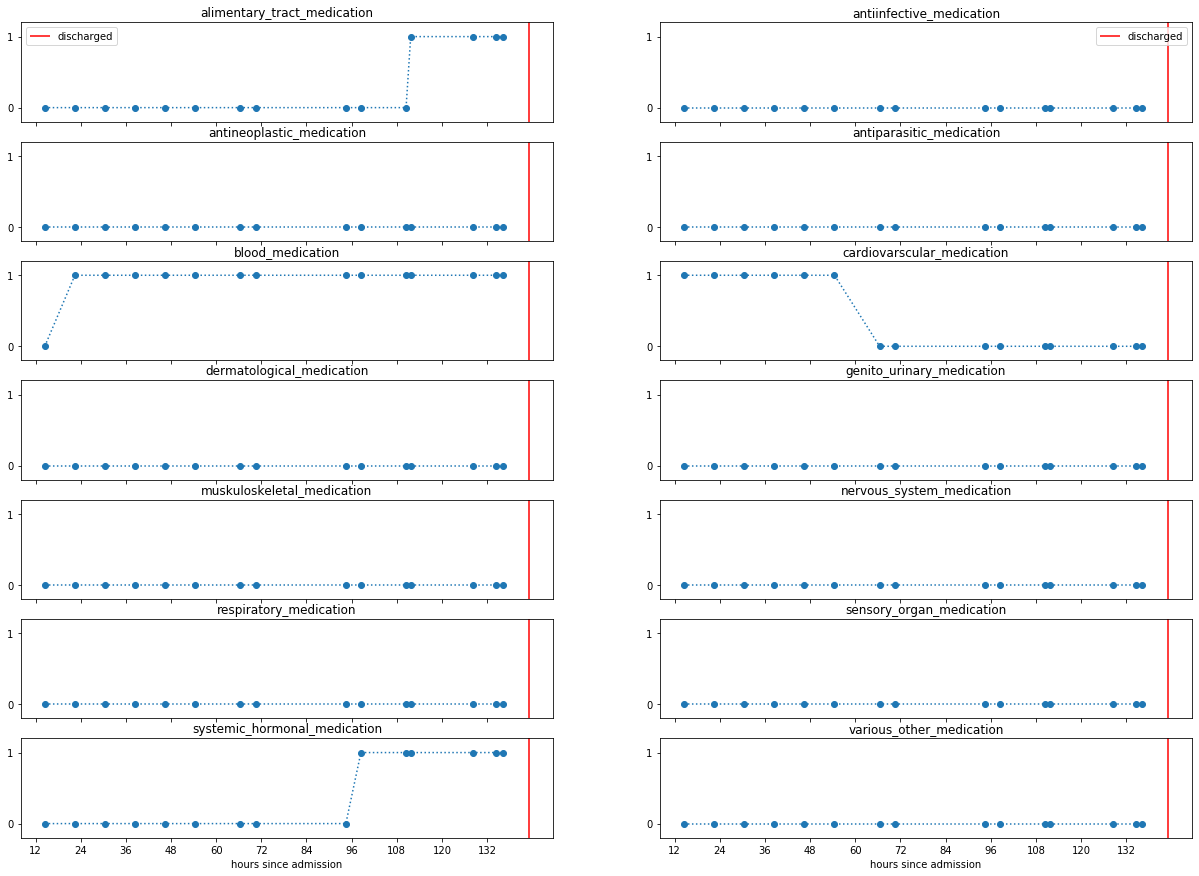

In [24]:
plot_hosp_id = 15968507
curr_medications_df = medications_df[medications_df.hospital_admission_id==plot_hosp_id]
time_col = parse_time_col(medications_data_dict)
t = curr_medications_df[time_col].values
icu_ts = 143.133

xticks = np.arange(0, max(t), 12)
f,  ax_grid= plt.subplots(7, 2, figsize=(21, 15), sharex=True)
axs = ax_grid.flatten()
for i in range(len(medication_cols)):
    med_vals = curr_medications_df[medication_cols[i]].values
    axs[i].plot(t, med_vals, marker='o', linestyle=':')
    axs[i].set_title(medication_cols[i])
    if (i==12) or (i==13):
        axs[i].set_xlabel('hours since admission')
        axs[i].set_xticks(xticks)
#     curr_medications_df[[time_col] + medication_cols].plot(x=time_col, y=medication_cols[i], ax=axs[i], kind='line', style='o')
    axs[i].set_ylim([-0.2, 1.2])
    axs[i].set_yticks([0, 1])
    axs[i].vlines(icu_ts, -0.2, 1.2, colors='r', label='discharged')
    if (i==0) or (i==1):
        axs[i].legend()

f.savefig('example_medications_plot.png')
plt.show()

In [13]:
len(medication_cols)

14

In [41]:
outcomes_df[outcomes_df.hospital_admission_id==plot_hosp_id]

,patient_id,hospital_admission_id,facility_code,transfer_to_icu_timestamp,transfer_to_ICU_outcome,inhospital_mortality_timestamp,inhospital_mortality_outcome,clinical_deterioration_timestamp,clinical_deterioration_outcome,stay_length
21,187,15968507,1,NaN,0,NaN,0,2023-03-05 17:40:00,0,143.133333


In [42]:
unfilt_medications_df = pd.read_csv('/home/prash/datasets/v20210119/HUF/medications.csv')

In [43]:
unfilt_medications_df[unfilt_medications_df.hospital_admission_id==plot_hosp_id]

,patient_id,hospital_admission_id,facility_code,timestamp,hours_since_admission,alimentary_tract_medication,blood_medication,cardiovarscular_medication,dermatological_medication,genito_urinary_medication,systemic_hormonal_medication,antiinfective_medication,antineoplastic_medication,muskuloskeletal_medication,nervous_system_medication,antiparasitic_medication,respiratory_medication,sensory_organ_medication,various_other_medication
84,187,15968507,1,2023-02-28 09:00:00,14.467,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,187,15968507,1,2023-02-28 17:00:00,22.467,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,187,15968507,1,2023-03-01 01:00:00,30.467,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,187,15968507,1,2023-03-01 09:00:00,38.467,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,187,15968507,1,2023-03-01 17:00:00,46.467,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,187,15968507,1,2023-03-02 01:00:00,54.467,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,187,15968507,1,2023-03-02 13:00:00,66.467,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,187,15968507,1,2023-03-02 17:00:00,70.467,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,187,15968507,1,2023-03-03 17:00:00,94.467,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,187,15968507,1,2023-03-03 21:00:00,98.467,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
